In [2]:
import pandas as pd
import pandasql
from pandasql import sqldf
from datetime import date

import matplotlib.pyplot as plt
import matplotlib_venn as venn
from matplotlib_venn import venn2

save_result = 1
cycle_yr = '2006'
# DON'T FORGET TO CHANGE CYCLE DATES IF CHANGING CYCLE_YR
startcyc = date(int(cycle_yr)-2,11,3) 
endcyc = date(int(cycle_yr),11,7) 

In [3]:
cycle_yr_abr = cycle_yr[2:4]
filepath_addit = "../raw data/oth"+ str(int(cycle_yr_abr)-2).zfill(2) + "/itoth" + str(int(cycle_yr)-2) + ".txt"
filepath_main = "../raw data/oth"+ cycle_yr_abr + "/itoth" + cycle_yr + ".txt"

In [4]:
colnm=['CMTE_ID','AMNDT_IND','RPT_TP','TRANSACTION_PGI','IMAGE_NUM','TRANSACTION_TP','ENTITY_TP','NAME','CITY','STATE',
       'ZIP_CODE','EMPLOYER','OCCUPATION','TRANSACTION_DT','TRANSACTION_AMT','OTHER_ID','TRAN_ID','FILE_NUM','MEMO_CD',
       'MEMO_TEXT','SUB_ID'
]
coltypes = {'CMTE_ID': str, 'AMNDT_IND':str, 'RPT_TP':str, 'TRANSACTION_PGI':str, 'IMAGE_NUM':str, 'TRANSACTION_TP':str, 
            'ENTITY_TP':str,'NAME':str, 'CITY':str, 'STATE':str, 'ZIP_CODE':str, 'EMPLOYER':str, 'OCCUPATION':str, 
            'TRANSACTION_DT':str, 'TRANSACTION_AMT':float, 'OTHER_ID':str, 'TRAN_ID':str, 'FILE_NUM':str, 'MEMO_CD':str, 
            'MEMO_TEXT':str, 'SUB_ID':str
           }
data_addit = pd.read_csv(filepath_addit, 
                    sep='|', header=None, names = colnm, dtype=coltypes)
data_main = pd.read_csv(filepath_main, 
                    sep='|', header=None, names = colnm, dtype=coltypes)

In [5]:
print(data_addit.shape)
data_addit.head()

(411455, 21)


CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM TRANSACTION_TP  \
0  C00386151         N     Q1               P  23020201726            16C   
1  C00379735         A     Q1               P  25971574853            24K   
2  C00219865         N     Q1               P  23020210063            24K   
3  C00219865         N     Q1               G  23020210063            24K   
4  C00219865         N     Q1               P  23020210063            24K   

  ENTITY_TP                             NAME         CITY STATE  ... EMPLOYER  \
0       NaN                              NaN          NaN   NaN  ...      NaN   
1       ORG  BEAUPREZ FOR CONGRESS  (CO/H07)  WHEAT RIDGE    CO  ...      NaN   
2       NaN                              NaN          NaN   NaN  ...      NaN   
3       NaN                              NaN          NaN   NaN  ...      NaN   
4       NaN                              NaN          NaN   NaN  ...      NaN   

  OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID         TRAN_ID  \
0        NaN       03242003         27500.0  S4KY00042             NaN   
1        NaN       02162003          1000.0  C00376152  0326200333E668   
2        NaN       01302003          2000.0  C00279901             NaN   
3        NaN       01302003          2000.0  C00279901             NaN   
4        NaN       02072003          1000.0  C00358895             NaN   

  FILE_NUM MEMO_CD MEMO_TEXT               SUB_ID  
0      NaN     NaN       NaN  1050520030000101517  
1   193080     NaN       NaN  4120820051062509975  
2      NaN     NaN       NaN  2043020031031291609  
3      NaN     NaN       NaN  2043020031031291610  
4      NaN     NaN       NaN  2043020031031291611  

[5 rows x 21 columns]

Okay now I'm going to filter it and save only the ones with transaction_pgi containing 2020 into their own dataframe.

In [6]:
# Check if there are any negative values for image_num, since for 2006 at least there shouldn't be
any(data_addit['IMAGE_NUM'].str[0]=='-')

False

In [27]:
explicitly_incycle_data_addit = data_addit[data_addit['TRANSACTION_PGI'].str.contains(cycle_yr, na=False)]
explicitly_incycle_data_addit

Empty DataFrame
Columns: [CMTE_ID, AMNDT_IND, RPT_TP, TRANSACTION_PGI, IMAGE_NUM, TRANSACTION_TP, ENTITY_TP, NAME, CITY, STATE, ZIP_CODE, EMPLOYER, OCCUPATION, TRANSACTION_DT, TRANSACTION_AMT, OTHER_ID, TRAN_ID, FILE_NUM, MEMO_CD, MEMO_TEXT, SUB_ID]
Index: []

[0 rows x 21 columns]

Using the election cycle dates, find any transaction that's not marked as in the election cycle but should be, and add those as well.
    I might have to do some extra research on how early before an election cycle starts, transactions can be made that count towards that.
* So, for the 2020 file, I will use the fact that the 2020 election cycle was [11-7-2018, 11-3-2020] and extract any transactions that (have a transaction_pgi containing 2020) OR (11-7-2018 <= transaction_dt <= 11-3-2020).
    * This is assuming that the dates in itoth2020 are actually from 2019 to 2020...I know from analyzing some of the other data that there are some weird records with like year 0 or year that's way later than it should be the data file.
    * Improvement Idea 1) a): Come back and investigate these weird dates, and decide what to do with them. For now, I'll just ignore them and not include them in my dataset.
    * Improvement Idea 1) b): Make sure that transactions for an election cycle can't take place before or after the election cycle dates...more of a boundary case
For now, I'll discard itoth2020.txt after I extract the 2020 election cycle. 
I can always redownload it from the FEC if I want to add in more records or do the 2020 election cycle, but rn it's taking up a lot of space on my computer.

In [28]:
data_addit[['TRANSACTION_DT']] = pd.to_datetime(data_addit['TRANSACTION_DT'], format='%m%d%Y').dt.date
data_addit[['TRANSACTION_DT']]

TRANSACTION_DT
0          2003-03-24
1          2003-02-16
2          2003-01-30
3          2003-01-30
4          2003-02-07
...               ...
411450     2004-10-08
411451     2004-10-01
411452     2004-10-12
411453     2004-10-12
411454     2005-01-31

[411455 rows x 1 columns]

Improvement Idea 1) d): Visualize the distribution of dates by histogramming it by years, then months for each year, then months, and days

## Don't forget to change the cycle dates!!!

In [29]:
#greater than the start date and smaller than the end date
mask = (data_addit['TRANSACTION_DT'] >= startcyc) & (data_addit['TRANSACTION_DT'] <= endcyc)
includeby_date_addit_data = data_addit.loc[mask]
includeby_date_addit_data

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM  \
8714    C00389445         A     YE               G  24020110440   
77529   C00341800         N     YE               P  24038300482   
77530   C00341800         N     YE               P  24038300482   
77531   C00341800         N     YE               P  24038300482   
77532   C00341800         N     YE               P  24038300483   
...           ...       ...    ...             ...          ...   
411241  C00309567         A     YE               G  11931539944   
411242  C00309567         A     YE               G  11931539944   
411292  C00089342         A    30G               G  12951884200   
411295  C00407775         N     YE               G  25038730167   
411454  C00369504         A     YE               P  26038942764   

       TRANSACTION_TP ENTITY_TP                 NAME          CITY STATE  ...  \
8714              24K       NaN                  NaN           NaN   NaN  ...   
77529             24K       NaN                  NaN           NaN   NaN  ...   
77530             24K       NaN                  NaN           NaN   NaN  ...   
77531             24K       NaN                  NaN           NaN   NaN  ...   
77532             24K       NaN                  NaN           NaN   NaN  ...   
...               ...       ...                  ...           ...   ...  ...   
411241            24A       ORG           WORLDCOMP,      STERLING    VA  ...   
411242            24A       ORG           WORLDCOMP,      STERLING    VA  ...   
411292            24K       CCM  EVAN BAYH COMMITTEE  INDIANAPOLIS    IN  ...   
411295            24E       NaN                  NaN           NaN   NaN  ...   
411454            24K       NaN                  NaN           NaN   NaN  ...   

       EMPLOYER OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID  \
8714        NaN        NaN     2004-11-12        107000.0  C00074450   
77529       NaN        NaN     2004-12-10           500.0  C00080655   
77530       NaN        NaN     2004-12-15           500.0  C00312090   
77531       NaN        NaN     2004-12-17           500.0  C00337428   
77532       NaN        NaN     2004-12-10          2000.0  C00080655   
...         ...        ...            ...             ...        ...   
411241      NaN        NaN     2004-12-31           389.0  P00003335   
411242      NaN        NaN     2004-12-31           714.0  P00003335   
411292      NaN        NaN     2004-11-09         -1000.0  C00306860   
411295      NaN        NaN     2004-11-28           520.0  P00003335   
411454      NaN        NaN     2005-01-31          5000.0  C00019075   

                     TRAN_ID FILE_NUM MEMO_CD                   MEMO_TEXT  \
8714                     NaN      NaN     NaN                         NaN   
77529                    NaN      NaN     NaN                         NaN   
77530                    NaN      NaN     NaN                         NaN   
77531                    NaN      NaN     NaN                         NaN   
77532                    NaN      NaN     NaN                         NaN   
...                      ...      ...     ...                         ...   
411241  01000703101000942201   746388     NaN                         NaN   
411242  01000703101000942401   746388     NaN                         NaN   
411292              20514777   785828     NaN  VOID - EVAN BAYH COMMITTEE   
411295                   NaN      NaN     NaN                         NaN   
411454                   NaN      NaN     NaN                         NaN   

                     SUB_ID  
8714    1070820110008804443  
77529   1021120040000143509  
77530   1021120040000143503  
77531   1021120040000143506  
77532   1021120040000143511  
...                     ...  
411241  4093020111143387878  
411242  4093020111143387879  
411292  4061220121157564230  
411295  2022320051054906637  
411454  1061920060000316396  

[12188 rows x 21 columns]

Improvement idea 2) Investigate the records that are within the 2020 election cycle transaction_dt, but are marked as P2018, which may be for the 2018 election cycle or it may be for the 2020 cycle, and the ones that are marked as G2018, which are probably not in the 2020 election cycle....for now I'll leave it as is but I should come back and fix this.

In [30]:
pd.merge(left=explicitly_incycle_data_addit, right=includeby_date_addit_data, left_on='SUB_ID', right_on='SUB_ID')

Empty DataFrame
Columns: [CMTE_ID_x, AMNDT_IND_x, RPT_TP_x, TRANSACTION_PGI_x, IMAGE_NUM_x, TRANSACTION_TP_x, ENTITY_TP_x, NAME_x, CITY_x, STATE_x, ZIP_CODE_x, EMPLOYER_x, OCCUPATION_x, TRANSACTION_DT_x, TRANSACTION_AMT_x, OTHER_ID_x, TRAN_ID_x, FILE_NUM_x, MEMO_CD_x, MEMO_TEXT_x, CMTE_ID_y, AMNDT_IND_y, RPT_TP_y, TRANSACTION_PGI_y, IMAGE_NUM_y, TRANSACTION_TP_y, ENTITY_TP_y, NAME_y, CITY_y, STATE_y, ZIP_CODE_y, EMPLOYER_y, OCCUPATION_y, TRANSACTION_DT_y, TRANSACTION_AMT_y, OTHER_ID_y, TRAN_ID_y, FILE_NUM_y, MEMO_CD_y, MEMO_TEXT_y, SUB_ID]
Index: []

[0 rows x 41 columns]

So there are 0 records that are in both.

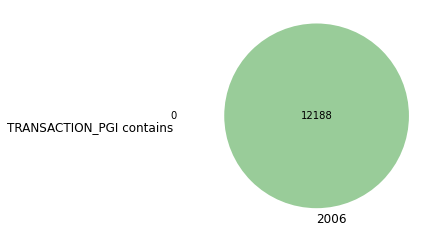

In [31]:
# Use the venn2 function
overlap = pd.merge(left=explicitly_incycle_data_addit, right=includeby_date_addit_data, left_on='SUB_ID', right_on='SUB_ID').shape[0]
# Find the number of rows of the ones that are explicitly included, and subtract from it the number that's in both
expincl_notin_dtrange = explicitly_incycle_data_addit.shape[0] - overlap
in_dtrange_not_expincl = includeby_date_addit_data.shape[0] - overlap
venn2(subsets = (expincl_notin_dtrange, in_dtrange_not_expincl , overlap), 
      set_labels = ('TRANSACTION_PGI contains', cycle_yr, 'TRANSACTION_DT in', cycle_yr, 'cycle date range'))
plt.show()

In [32]:
incycle_data_addit = pd.concat([explicitly_incycle_data_addit, includeby_date_addit_data])
# Drop duplicates from the concatenated dataset
incycle_data_addit.drop_duplicates(subset=['SUB_ID'], inplace=True)
incycle_data_addit

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM  \
8714    C00389445         A     YE               G  24020110440   
77529   C00341800         N     YE               P  24038300482   
77530   C00341800         N     YE               P  24038300482   
77531   C00341800         N     YE               P  24038300482   
77532   C00341800         N     YE               P  24038300483   
...           ...       ...    ...             ...          ...   
411241  C00309567         A     YE               G  11931539944   
411242  C00309567         A     YE               G  11931539944   
411292  C00089342         A    30G               G  12951884200   
411295  C00407775         N     YE               G  25038730167   
411454  C00369504         A     YE               P  26038942764   

       TRANSACTION_TP ENTITY_TP                 NAME          CITY STATE  ...  \
8714              24K       NaN                  NaN           NaN   NaN  ...   
77529             24K       NaN                  NaN           NaN   NaN  ...   
77530             24K       NaN                  NaN           NaN   NaN  ...   
77531             24K       NaN                  NaN           NaN   NaN  ...   
77532             24K       NaN                  NaN           NaN   NaN  ...   
...               ...       ...                  ...           ...   ...  ...   
411241            24A       ORG           WORLDCOMP,      STERLING    VA  ...   
411242            24A       ORG           WORLDCOMP,      STERLING    VA  ...   
411292            24K       CCM  EVAN BAYH COMMITTEE  INDIANAPOLIS    IN  ...   
411295            24E       NaN                  NaN           NaN   NaN  ...   
411454            24K       NaN                  NaN           NaN   NaN  ...   

       EMPLOYER OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID  \
8714        NaN        NaN     2004-11-12        107000.0  C00074450   
77529       NaN        NaN     2004-12-10           500.0  C00080655   
77530       NaN        NaN     2004-12-15           500.0  C00312090   
77531       NaN        NaN     2004-12-17           500.0  C00337428   
77532       NaN        NaN     2004-12-10          2000.0  C00080655   
...         ...        ...            ...             ...        ...   
411241      NaN        NaN     2004-12-31           389.0  P00003335   
411242      NaN        NaN     2004-12-31           714.0  P00003335   
411292      NaN        NaN     2004-11-09         -1000.0  C00306860   
411295      NaN        NaN     2004-11-28           520.0  P00003335   
411454      NaN        NaN     2005-01-31          5000.0  C00019075   

                     TRAN_ID FILE_NUM MEMO_CD                   MEMO_TEXT  \
8714                     NaN      NaN     NaN                         NaN   
77529                    NaN      NaN     NaN                         NaN   
77530                    NaN      NaN     NaN                         NaN   
77531                    NaN      NaN     NaN                         NaN   
77532                    NaN      NaN     NaN                         NaN   
...                      ...      ...     ...                         ...   
411241  01000703101000942201   746388     NaN                         NaN   
411242  01000703101000942401   746388     NaN                         NaN   
411292              20514777   785828     NaN  VOID - EVAN BAYH COMMITTEE   
411295                   NaN      NaN     NaN                         NaN   
411454                   NaN      NaN     NaN                         NaN   

                     SUB_ID  
8714    1070820110008804443  
77529   1021120040000143509  
77530   1021120040000143503  
77531   1021120040000143506  
77532   1021120040000143511  
...                     ...  
411241  4093020111143387878  
411242  4093020111143387879  
411292  4061220121157564230  
411295  2022320051054906637  
411454  1061920060000316396  

[12188 rows x 21 columns]

# 2006 Cycle Data from the 2005-2006 itoth data

In [33]:
print(data_main.shape)
data_main.head()

(423705, 21)


CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM TRANSACTION_TP  \
0  C00080655         N     Q1               P  25020162400            24K   
1  C00080655         N     Q1               P  25020162399            24K   
2  C00080655         N     Q1               G  25020162399            24K   
3  C00080655         N     Q1               P  25020162399            24K   
4  C00080655         N     Q1               P  25020162400            24K   

  ENTITY_TP NAME CITY STATE  ... EMPLOYER OCCUPATION TRANSACTION_DT  \
0       NaN  NaN  NaN   NaN  ...      NaN        NaN       03102005   
1       NaN  NaN  NaN   NaN  ...      NaN        NaN       03312005   
2       NaN  NaN  NaN   NaN  ...      NaN        NaN       03312005   
3       NaN  NaN  NaN   NaN  ...      NaN        NaN       02222005   
4       NaN  NaN  NaN   NaN  ...      NaN        NaN       02222005   

  TRANSACTION_AMT   OTHER_ID TRAN_ID FILE_NUM MEMO_CD MEMO_TEXT  \
0          1000.0  C00027987     NaN      NaN     NaN       NaN   
1          1000.0  C00344051     NaN      NaN     NaN       NaN   
2          2000.0  C00344051     NaN      NaN     NaN       NaN   
3          2000.0  C00349506     NaN      NaN     NaN       NaN   
4          1100.0  C00344473     NaN      NaN     NaN       NaN   

                SUB_ID  
0  2042920051056615089  
1  2042920051056615086  
2  2042920051056615087  
3  2042920051056615088  
4  2042920051056615090  

[5 rows x 21 columns]

In [34]:
cy06fr06 = data_main[data_main['TRANSACTION_PGI'].str.contains(cycle_yr, na=False)]
cy06fr06.shape

(352, 21)

In [35]:
## Find 1016-01-02
#data2014[data2014['TRANSACTION_DT'].str.contains("....1014", na=False)]

Ahh okay I see, so there are three rows that are supposedly from January 2nd, 1016 - which is clearly nonsensical. This was probably a typo where someone typed 1016 instead of 2016
Improvement idea 1) c) ii) I will validate the ground truth by finding the original filing.
For now, I will get rid of these rows, then convert it to a date.

In [36]:
#data2012 = data2012[~data2012['TRANSACTION_DT'].str.contains("....1016", na=False)]
#data2016.shape

In [37]:
data_main[['TRANSACTION_DT']] = pd.to_datetime(data_main['TRANSACTION_DT'], format='%m%d%Y').dt.date
data_main[['TRANSACTION_DT']]

TRANSACTION_DT
0          2005-03-10
1          2005-03-31
2          2005-03-31
3          2005-02-22
4          2005-02-22
...               ...
423700     2006-10-26
423701     2006-10-30
423702     2006-11-05
423703     2020-11-03
423704     2006-10-18

[423705 rows x 1 columns]

In [38]:
#greater than the start date and smaller than the end date
mask = (data_main['TRANSACTION_DT'] >= startcyc) & (data_main['TRANSACTION_DT'] <= endcyc)
dates_in_2006cyc_fr2006 = data_main.loc[mask]
dates_in_2006cyc_fr2006.shape

(412647, 21)

Hmm, how many of the 989,436 records I found contain 2020 in the transaction_pgi? What does the venn diagram look like with transaction_pgi containing 2020? How many are both? How many are just in the date range? How many just contain 2020 in transaction_pgi?

In [39]:
pd.merge(left=cy06fr06, right=dates_in_2006cyc_fr2006, left_on='SUB_ID', right_on='SUB_ID').shape

(345, 41)

In [40]:
print('So there are 345 records that are in both, and since there were 352 records that contained ', cycle_yr,  
      'in its transaction_pgi, that means that there are 352-345 = 7 records that weren\'t in the date range \
      but did contain', cycle_yr ,'in the transaction_pgi \n. Since there were 412647 rows that were in the date range, \
      there were 412647-345= 412302 records that were in the', cycle_yr ,'cycle date range but didn\'t have \
      transaction_pgi containing', cycle_yr ,'.\n There should be 352+412647-345 = 412654 rows in the dataframe \
      consisting of', cycle_yr ,'cycle transactions.')

So there are 345 records that are in both, and since there were 352 records that contained  2006 in its transaction_pgi, that means that there are 352-345 = 7 records that weren't in the date range       but did contain 2006 in the transaction_pgi 
. Since there were 412647 rows that were in the date range,       there were 412647-345= 412302 records that were in the 2006 cycle date range but didn't have       transaction_pgi containing 2006 .
 There should be 352+412647-345 = 412654 rows in the dataframe       consisting of 2006 cycle transactions.


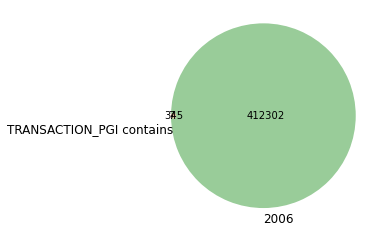

In [41]:
# Use the venn2 function
venn2(subsets = (7 , 412302  , 345 ), set_labels = ('TRANSACTION_PGI contains', cycle_yr, 'TRANSACTION_DT in', cycle_yr ,'cycle date range'))
plt.show()
# I wonder what is the transaction_dt range and distribution for records where transaction_pgi contains 2020, and how far off it is from the 2020 election cycle.
    # Improvement idea 2) b) Investigate this to see if it can help me get the correct dates.

In [42]:
cy06fr06v2 = pd.concat([cy06fr06, dates_in_2006cyc_fr2006])
# Drop duplicates from the concatenated dataset
cy06fr06v2.drop_duplicates(subset=['SUB_ID'], inplace=True)

In [43]:
# First, vertically concatenate the two dataframes
# then save the result to a csv
# check the number of rows in cy18fr16 and cy18fr18
print('Shape for', cycle_yr ,'election cycle transactions from', str(int(cycle_yr)-2), ': ', str(incycle_data_addit.shape))
print('Shape for', cycle_yr ,'election cycle transactions from', cycle_yr,': ', str(cy06fr06v2.shape))
print('There should be', incycle_data_addit.shape[0]+cy06fr06v2.shape[0], 'rows total for', cycle_yr, 'election cycle transactions.' )

Shape for 2006 election cycle transactions from 2004 :  (12188, 21)
Shape for 2006 election cycle transactions from 2006 :  (412654, 21)
There should be 424842 rows total for 2006 election cycle transactions.


In [44]:
fec_cy2006 = pd.concat([incycle_data_addit, cy06fr06v2], ignore_index=True)
fec_cy2006

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM  \
0       C00389445         A     YE               G  24020110440   
1       C00341800         N     YE               P  24038300482   
2       C00341800         N     YE               P  24038300482   
3       C00341800         N     YE               P  24038300482   
4       C00341800         N     YE               P  24038300483   
...           ...       ...    ...             ...          ...   
424837  C70000112         N     YE             NaN  27039372040   
424838  C70000112         N     YE             NaN  27039372044   
424839  C70000112         N     YE             NaN  27039372047   
424840  C30000517         N     24             NaN  26960664016   
424841  C30000517         N     24             NaN  26960544369   

       TRANSACTION_TP ENTITY_TP                  NAME          CITY STATE  \
0                 24K       NaN                   NaN           NaN   NaN   
1                 24K       NaN                   NaN           NaN   NaN   
2                 24K       NaN                   NaN           NaN   NaN   
3                 24K       NaN                   NaN           NaN   NaN   
4                 24K       NaN                   NaN           NaN   NaN   
...               ...       ...                   ...           ...   ...   
424837            24N       NaN                   NaN           NaN   NaN   
424838            24F       NaN                   NaN           NaN   NaN   
424839            24F       NaN                   NaN           NaN   NaN   
424840             29       ORG  GREAT AMERICAN MEDIA  PHILADELPHIS    PA   
424841             29       ORG  GREAT AMERICAN MEDIA  PHILADELPHIA    PA   

        ... EMPLOYER OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID  \
0       ...      NaN        NaN     2004-11-12        107000.0  C00074450   
1       ...      NaN        NaN     2004-12-10           500.0  C00080655   
2       ...      NaN        NaN     2004-12-15           500.0  C00312090   
3       ...      NaN        NaN     2004-12-17           500.0  C00337428   
4       ...      NaN        NaN     2004-12-10          2000.0  C00080655   
...     ...      ...        ...            ...             ...        ...   
424837  ...      NaN        NaN     2006-10-20         21663.0  S4PA00063   
424838  ...      NaN        NaN     2006-10-26          1881.0  H6MN02107   
424839  ...      NaN        NaN     2006-10-30          2379.0  H4PA16051   
424840  ...      NaN        NaN     2006-11-05         21191.0        NaN   
424841  ...      NaN        NaN     2006-10-18        500000.0        NaN   

             TRAN_ID FILE_NUM MEMO_CD MEMO_TEXT               SUB_ID  
0                NaN      NaN     NaN       NaN  1070820110008804443  
1                NaN      NaN     NaN       NaN  1021120040000143509  
2                NaN      NaN     NaN       NaN  1021120040000143503  
3                NaN      NaN     NaN       NaN  1021120040000143506  
4                NaN      NaN     NaN       NaN  1021120040000143511  
...              ...      ...     ...       ...                  ...  
424837           NaN      NaN     NaN       NaN  1033020070000535726  
424838           NaN      NaN     NaN       NaN  1033020070000535727  
424839           NaN      NaN     NaN       NaN  1033020070000535728  
424840  SBF93.000001   258104     NaN       NaN  4062120071078071728  
424841  SBF93.000001   245500     NaN       NaN  4062120071078071726  

[424842 rows x 21 columns]

Now that I have the itoth data from the 2016 election cycle, I'm going to extract it to the relevant records, which is those with (transaction_tp = '24Z') and (entity_tp<>'IND' or entity_tp is null). <br>
Then, I will extract the first digits of the transaction amounts into their own column.

In [45]:
fec_cy2006_ctc = fec_cy2006[(fec_cy2006["TRANSACTION_TP"]=='24Z') & ((fec_cy2006["ENTITY_TP"]!='IND') | (fec_cy2006["ENTITY_TP"].isnull()))] 

In [46]:
# Extract the first digits of transaction_amt
fec_cy2006_ctc = fec_cy2006_ctc.assign(amt_firstdig=fec_cy2006_ctc['TRANSACTION_AMT'].astype(str).str[:1].values)
fec_cy2006_ctc[['TRANSACTION_AMT', 'amt_firstdig']]

TRANSACTION_AMT amt_firstdig
286              2250.0            2
316               931.0            9
512                37.0            3
513               438.0            4
514               265.0            2
...                 ...          ...
424081            356.0            3
424114            150.0            1
424115            150.0            1
424121            156.0            1
424123            150.0            1

[8093 rows x 2 columns]

In [47]:
# drop those where transaction_amt not in [1,9], eg. if it's 0 or negative
firstdigitslist = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
fec_cy2006_ctc = fec_cy2006_ctc[fec_cy2006_ctc['amt_firstdig'].isin(firstdigitslist)]

In [48]:
if save_result == 1:
    fec_cy2006_ctc.to_csv('FEC-itoth-'+ cycle_yr +'cycle-ctc-inkind.csv', sep = '|', index = False)